# We use two visualiztion method: Seaborn and Altair.
Then we monitor the performance





In [1]:
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
import psutil
import time
import multiprocessing
import os

Load the processed data.

In [2]:
file_path = 'processed_data.csv'

# // Read the CSV file into a DataFrame then sample it.
df = pd.read_csv(file_path)
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_sampled = df_numeric.sample(n=min(1000, len(df_numeric)), random_state=42)

A function to monitor each method's performance

In [3]:
def monitor_performance(target_func, output_queue, timing_queue, label):
    try:
        process = psutil.Process(os.getpid())
        mem_before = process.memory_info().rss / 1024 ** 2
        cpu_before = process.cpu_percent(interval=0.1)
        start = time.time()

        # Run the actual visualization function
        target_func()

        elapsed = time.time() - start
        mem_after = process.memory_info().rss / 1024 ** 2
        cpu_after = process.cpu_percent(interval=0.1)

        output_queue.put(f"[{label}] Visualization completed successfully.")
        timing_queue.put((label, round(elapsed, 4), round(mem_after - mem_before, 2), round((cpu_before + cpu_after) / 2, 2)))
    except Exception as e:
        output_queue.put(f"[{label} ERROR] {str(e)}")

In [4]:
# Visualization Method 1: Seaborn Heatmap
def seaborn_heatmap():
    df = df_sampled
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), cmap='coolwarm')
    plt.title("Seaborn Heatmap")
    plt.tight_layout()
    plt.savefig("seaborn_heatmap.png")
    plt.close()


In [5]:
# Visualization Method 2: Altair Interactive Heatmap
def altair_heatmap():
    df = df_sampled
    corr = df.corr().stack().reset_index()
    corr.columns = ['feature1', 'feature2', 'correlation']
    chart = alt.Chart(corr).mark_rect().encode(
        x='feature1:O',
        y='feature2:O',
        color='correlation:Q'
    ).properties(width=500, height=400)
    chart.save("altair_heatmap.html")

In [6]:
def plot_results(timings):
    df = pd.DataFrame(timings, columns=["Method", "Time (s)", "Memory (MB)", "Avg CPU (%)"])
    print("\n📊 Performance Table:\n", df)

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].bar(df["Method"], df["Time (s)"], color=['skyblue', 'lightgreen'])
    axs[0].set_title("Execution Time (s)")

    axs[1].bar(df["Method"], df["Memory (MB)"], color=['skyblue', 'lightgreen'])
    axs[1].set_title("Memory Usage (MB)")


    plt.suptitle("Visualization Method Performance Comparison")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("visualization_comparison.png")
    plt.show()


[PROCESS SCHEDULING] Starting subprocesses...

--- Seaborn Output ---
[Seaborn] Visualization completed successfully.

--- Altair Output ---
[Altair] Visualization completed successfully.

📊 Performance Table:
     Method  Time (s)  Memory (MB)  Avg CPU (%)
0   Altair    0.1433         8.76          0.0
1  Seaborn    0.9441        16.77          0.0


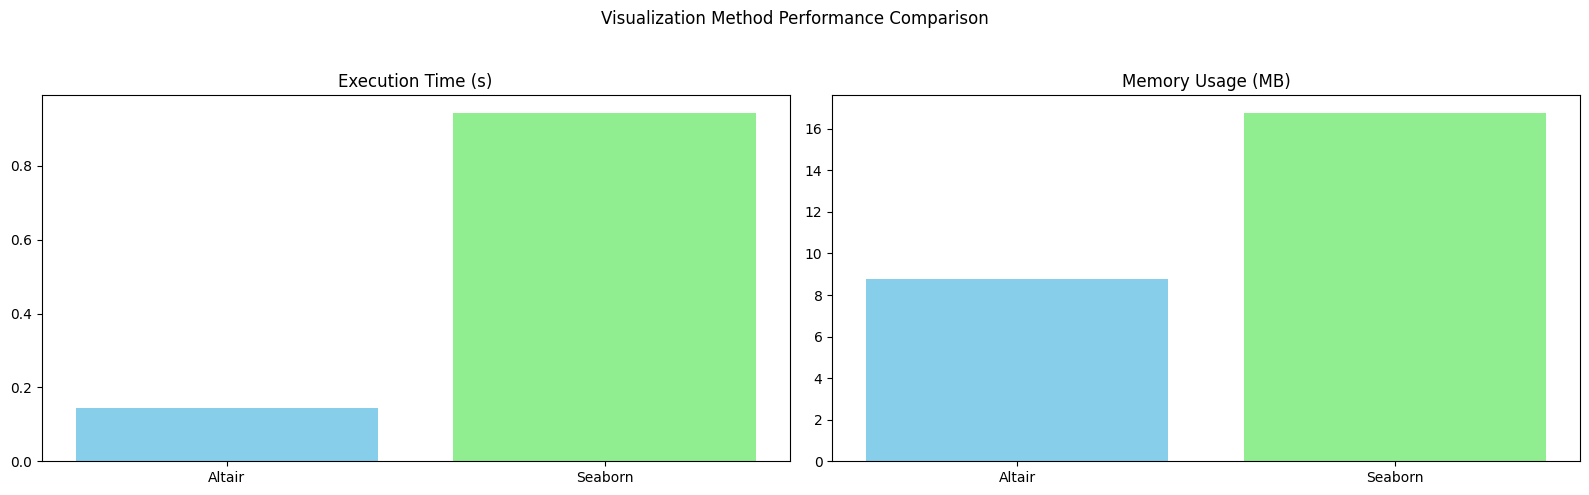


[DONE] Visualization performance benchmarking completed.


In [8]:
# ✅ Main Execution
if __name__ == '__main__':


    output_queue1 = multiprocessing.Queue()
    output_queue2 = multiprocessing.Queue()
    timing_queue = multiprocessing.Queue()

    print("\n[PROCESS SCHEDULING] Starting subprocesses...")

    p1 = multiprocessing.Process(
        target=monitor_performance,
        args=(seaborn_heatmap, output_queue1, timing_queue, "Seaborn")
    )
    p2 = multiprocessing.Process(
        target=monitor_performance,
        args=(altair_heatmap, output_queue2, timing_queue, "Altair")
    )

    p1.start()
    p2.start()
    p1.join()
    p2.join()

    print("\n--- Seaborn Output ---")
    while not output_queue1.empty():
        print(output_queue1.get())

    print("\n--- Altair Output ---")
    while not output_queue2.empty():
        print(output_queue2.get())

    timings = []
    while not timing_queue.empty():
        timings.append(timing_queue.get())

    plot_results(timings)
    print("\n[DONE] Visualization performance benchmarking completed.")

Visualize the performances of the two method.